# Motherhood in the Workforce: Predicting salary and work sector

We have explored what it is like as a women in the STEM field by performing an exploratory data analysis of the dataset obtained from IPUMS HigherEd. Once it has been established that men recieve a higher salary than women despite having the same degrees, we further explored what it is like for women with children. In the statistical analysis of this data, we found that men with children still make 39% more than women with children!

In this notebook, I will use machine learning skills to predict the income and work sector best suited for those with children. The hope is to answer questions regarding what kind of pay and type of jobs mothers should expect to recieve in the workforce.

In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline 

In [2]:
#import stats module
from scipy.stats import ttest_ind, chi2_contingency
import statsmodels.api as sm

In [3]:
#import sklearn modules
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB

In [4]:
#import data from csv file with series of null values
df = pd.read_csv('highered_00005.csv', na_values=[96, 99, 98, 9996, 9998, 9999, 999996, 999998, 999999, 9999998, 9999999])

# Explanatioin of Data

This notebook will only predict using entries with a job and children. Irrelevant columns and missing data will be dropped. For further explanations for each features, refer to this site: https://highered.ipums.org/highered/survey_designs.shtml

In [5]:
#set data to contain employed individuals with children
df_employed = df[df['LFSTAT']==1]
df_emp_child = df_employed[df_employed['CHTOT']!=0]

#drop irrelevant columns
df_emp_child_drop = df_emp_child.drop(['WEIGHT', 'SAMPLE', 'SURID', 'RACETH','LFSTAT','CHFAM', 'CHTOT'], axis=1)
df_c = df_emp_child_drop.dropna()

In [6]:
#check out data
df_c.info()
df_c.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176857 entries, 0 to 206702
Data columns (total 11 columns):
PERSONID    176857 non-null int64
YEAR        176857 non-null int64
AGE         176857 non-null int64
GENDER      176857 non-null int64
DGRDG       176857 non-null int64
EMSEC       176857 non-null float64
EMSIZE      176857 non-null float64
NEWBUS      176857 non-null float64
WAPRSM      176857 non-null float64
SUPWK       176857 non-null float64
SALARY      176857 non-null float64
dtypes: float64(6), int64(5)
memory usage: 16.2 MB


Index(['PERSONID', 'YEAR', 'AGE', 'GENDER', 'DGRDG', 'EMSEC', 'EMSIZE',
       'NEWBUS', 'WAPRSM', 'SUPWK', 'SALARY'],
      dtype='object')

In [7]:
df_c.describe()

,PERSONID,YEAR,AGE,GENDER,DGRDG,EMSEC,EMSIZE,NEWBUS,WAPRSM,SUPWK,SALARY
count,1.768570e+05,176857.000000,176857.000000,176857.000000,176857.000000,176857.000000,176857.000000,176857.000000,176857.000000,176857.000000,176857.000000
mean,7.536877e+16,2008.544084,44.234890,1.609707,2.051081,3.256235,5.450844,0.062367,2.874842,0.434051,74835.432016
std,5.028187e+16,4.970323,11.923861,0.487817,0.940471,1.024139,2.411137,0.241821,1.490828,0.495633,39472.265874
min,2.000000e+16,2003.000000,23.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000904e+16,2003.000000,34.000000,1.000000,1.000000,2.000000,4.000000,0.000000,1.000000,0.000000,46000.000000
50%,5.000004e+16,2013.000000,43.000000,2.000000,2.000000,4.000000,6.000000,0.000000,3.000000,0.000000,70000.000000
75%,1.300091e+17,2013.000000,53.000000,2.000000,3.000000,4.000000,8.000000,0.000000,4.000000,1.000000,100000.000000
max,1.401011e+17,2013.000000,75.000000,2.000000,4.000000,4.000000,8.000000,1.000000,5.000000,1.000000,150000.000000


C:\Users\vangk\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


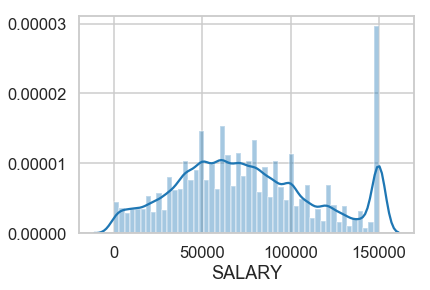

In [8]:
#Visual check of dependent variable SALARY
sns.distplot(df_c['SALARY'])

In [9]:
#Correlation check
print('Top correlated:')
print(df_c.corr()['SALARY'].sort_values(ascending=False).head(6))
print('Top reverse correlated:')
print(df_c.corr()['SALARY'].sort_values(ascending=True).head(5))

Top correlated:
SALARY    1.000000
SUPWK     0.293042
DGRDG     0.270397
GENDER    0.252219
EMSEC     0.214140
AGE       0.205010
Name: SALARY, dtype: float64
Top reverse correlated:
PERSONID   -0.127635
WAPRSM     -0.035081
NEWBUS     -0.033151
YEAR        0.069492
EMSIZE      0.171897
Name: SALARY, dtype: float64


We see here from the correlation check the top 5 features that have a positive correlation with salary is supervisory work, degree, gender, employee sector, and age. Take note that gender made it to the top 3!

## Linear Regression Model
Train out regression model to predict salary based on age. All other features are dropped because they have text info that the linear regression model can't use.

In [10]:
X = df_c['AGE'].values
y = df_c['SALARY'].values

X = X.reshape(-1,1)
y = y.reshape(-1,1)

0.042029163057773156


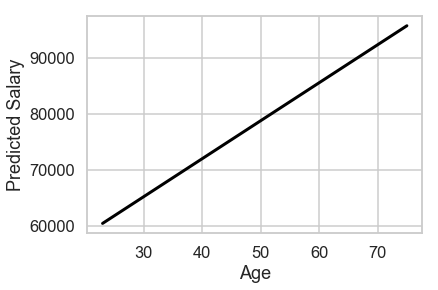

In [14]:
reg = LinearRegression()
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
reg.fit(X, y)
y_pred = reg.predict(prediction_space)
print(reg.score(X, y))
plt.plot(prediction_space, y_pred, color='black', linewidth=3)
plt.xlabel('Age')
plt.ylabel('Predicted Salary')
plt.show()

In [15]:
#create train test split case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('R^2:{}'.format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root mean squared error:{}'.format(rmse))

R^2:0.04318833871690786
Root mean squared error:38538.56641262462


We see here that age of people with children is not a good predictor of salary with an R squared value of 0.04. This is due to salary and age not sharing a linear relationship. As a result, using linear regression to predict salary based on age is not a good model.

In [16]:
cv_scores = cross_val_score(reg,X,y, cv=3)
print(cv_scores)
print('Average 3-fold cv scores:{}'.format(np.mean(cv_scores)))

[-0.04755807 -0.01978406  0.0408899 ]
Average 3-fold cv scores:-0.008817408840479731


In [17]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [18]:
# Check statistical significance.
m = ols('SALARY ~ AGE',df_c).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     7759.
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        07:48:38   Log-Likelihood:            -2.1189e+06
No. Observations:              176857   AIC:                         4.238e+06
Df Residuals:                  176855   BIC:                         4.238e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.482e+04    352.971    126.965      0.0

There is a ton of information in this output. But we'll concentrate on the coefficient table (middle table). We can interpret the AGE coefficient (678.66) by noticing that the p-value (under P>|t|) is so small, basically zero. This means that the AGE is a statisticall significant predictor of SALARY.

## Classification 
Most of the data are labeled and those with the highest correlation with salary are either binary or categorical. We see that age isn't the best predictor of salary for individuals with children. As a result, we will convert salary into binary and use two classification methods to predict salary of women with children: Logistic Regression and Random Forest Classifier

In [19]:
# define a function to change the salary column to a salary level column
def salary_bracket(ls):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s<60000:
            new_s[i] = 0
        else:
            new_s[i] = 1
    return new_s

# define a dataframe that only contains salary larger than 0 (eliminate the entry fault)
df_csal =[]
df_csal = df_c[(df_c['SALARY']>0)]



new_salary = salary_bracket(df_csal['SALARY'])

In [17]:
type(new_salary)

numpy.ndarray

In [20]:
#add new_salary to df_csal_nod
df_csal_nod = []
df_csal_nod = df_csal.assign(salary_d=pd.Series(new_salary).values)
df_csal_nod.salary_d = df_csal_nod.salary_d.astype('category')
df_csal_nod=df_csal_nod.drop(['SALARY'], axis=1)

In [21]:
#check new dataframe
df_csal_nod.head()

,PERSONID,YEAR,AGE,GENDER,DGRDG,EMSEC,EMSIZE,NEWBUS,WAPRSM,SUPWK,salary_d
0,50000030000000003,2003,47,1,1,1.0,3.0,0.0,2.0,1.0,0.0
1,50000030000000004,2003,66,2,1,4.0,1.0,0.0,1.0,1.0,1.0
2,50000030000000005,2003,60,1,1,4.0,6.0,0.0,3.0,1.0,1.0
3,50000030000000006,2003,30,2,2,4.0,8.0,0.0,1.0,1.0,1.0
5,50000030000000105,2003,51,2,1,4.0,8.0,0.0,3.0,1.0,1.0


In [20]:
type(df_csal_nod)

pandas.core.frame.DataFrame

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

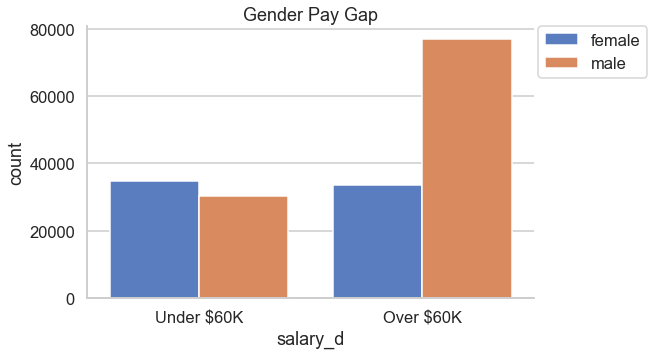

In [22]:
#bar plot of gender and salary 
fig=plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)
sns.countplot(data=df_csal_nod, x = 'salary_d', hue= 'GENDER', palette="muted", ax=ax)
sns.despine()
plt.title('Gender Pay Gap')
ax.set_xticklabels(['Under $60K', 'Over $60K'])
lgd=ax.legend(['female', 'male'], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.tight_layout

In the barplot above we see that a lot more men make over $60K than women do. For more overview of this disparity view EDA notebook

## Data exploration

In [24]:
df_csal_nod['salary_d'].value_counts()

1.0    110568
0.0     65219
Name: salary_d, dtype: int64

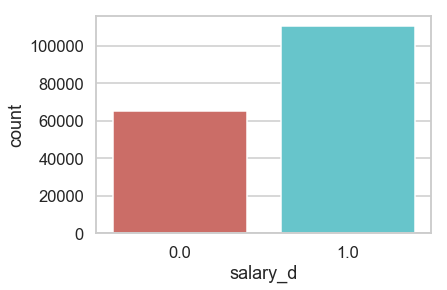

In [25]:
sns.countplot(x='salary_d', data=df_csal_nod, palette='hls')
plt.show()

In [26]:
count_u60 = len(df_csal_nod[df_csal_nod['salary_d']==0.0])
count_o60 = len(df_csal_nod[df_csal_nod['salary_d']==1.0])
pct_u60 = count_u60/(count_u60+count_o60)
print('percentage of under 60k is:{}'.format(pct_u60*100))
pct_o60 = count_o60/(count_u60+count_o60)
print('percentage of over 60k is:{}'.format(pct_o60*100))

percentage of under 60k is:37.10115082457747
percentage of over 60k is:62.898849175422534


Overall, the classes are imbalanced and require fixing. Let's explore some more.

In [27]:
df_csal_nod.groupby('salary_d').mean()

,PERSONID,YEAR,AGE,GENDER,DGRDG,EMSEC,EMSIZE,NEWBUS,WAPRSM,SUPWK
salary_d,,,,,,,,,,
0.0,8.231131e+16,2008.322069,41.770021,1.464696,1.826032,2.976265,4.867784,0.07001,2.986292,0.288689
1.0,7.120499e+16,2008.673070,45.650333,1.695635,2.185090,3.417779,5.820572,0.05536,2.805911,0.520639


The average age of people making less than 60k is 42 compared to those making more than 60k is 46.

## Create dummy variables

In [28]:
cat_vars=['SUPWK', 'DGRDG', 'GENDER', 'EMSEC', 'EMSIZE']
for var in cat_vars:
    cat_list='var'+ '_'+ var
    cat_list = pd.get_dummies(df_csal_nod[var], prefix=var)
    data = df_csal_nod.join(cat_list)
    df_csal_nod = data
    
cat_vars = ['SUPWK', 'DGRDG', 'GENDER', 'EMSEC', 'EMSIZE']
data_vars = df_csal_nod.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]

In [29]:
data_final = data[to_keep]
data_final.columns.values

array(['PERSONID', 'YEAR', 'AGE', 'NEWBUS', 'WAPRSM', 'salary_d',
       'SUPWK_0.0', 'SUPWK_1.0', 'DGRDG_1', 'DGRDG_2', 'DGRDG_3',
       'DGRDG_4', 'GENDER_1', 'GENDER_2', 'EMSEC_1.0', 'EMSEC_2.0',
       'EMSEC_3.0', 'EMSEC_4.0', 'EMSIZE_1.0', 'EMSIZE_2.0', 'EMSIZE_3.0',
       'EMSIZE_4.0', 'EMSIZE_5.0', 'EMSIZE_6.0', 'EMSIZE_7.0',
       'EMSIZE_8.0'], dtype=object)

## Check for over-sampling

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
#identify variables
X = data_final.loc[:, data_final.columns != 'salary_d']
y = data_final.loc[:, data_final.columns == 'salary_d']

In [32]:
# split data
os = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
columns = X_train.columns

# balance training data set
os_data_X, os_data_y = os.fit_sample(X_train, y_train.values.ravel())
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['salary_d'])

#check numbers of data
print('Length of oversampled data is',len(os_data_X))
print('Number of under $60k in oversampled data',len(os_data_y[os_data_y['salary_d']==0]))
print('Number of over $60k in oversampled data',len(os_data_y[os_data_y['salary_d']==1]))
print('Proportion of under $60k in oversampled data',len(os_data_y[os_data_y['salary_d']==0])/len(os_data_X))
print('Proportion of over $60k in oversampled data',len(os_data_y[os_data_y['salary_d']==1])/len(os_data_X))

Length of oversampled data is 154632
Number of under $60k in oversampled data 77316
Number of over $60k in oversampled data 77316
Proportion of under $60k in oversampled data 0.5
Proportion of over $60k in oversampled data 0.5


Here we can see that the data is now perfectly balanced!

In [33]:
from sklearn.feature_selection import RFE

In [34]:
logreg = LogisticRegression(solver='lbfgs')

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True False  True  True  True  True False  True  True  True
  True  True  True  True  True  True False  True  True False False  True
  True]
[1 1 1 2 1 1 1 1 5 1 1 1 1 1 1 1 1 1 3 1 1 4 6 1 1]


In [46]:
cols = ['AGE', 'WAPRSM', 
        'SUPWK_0.0', 'SUPWK_1.0', 'DGRDG_1', 'DGRDG_3',
       'DGRDG_4', 'GENDER_1', 'GENDER_2', 'EMSEC_1.0', 'EMSEC_2.0',
       'EMSEC_3.0', 'EMSEC_4.0', 'EMSIZE_1.0', 'EMSIZE_3.0',
       'EMSIZE_4.0', 'EMSIZE_7.0','EMSIZE_8.0']

# update columns in training set
X_os = os_data_X[cols]
y_os = np.ravel(os_data_y, order='C')

## Implement Logistic Regression Model

In [49]:
# Instantiate and fit model
logreg = LogisticRegression(solver='liblinear', max_iter=300)
logreg.fit(X_os, y_os)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [50]:
# predict on test set
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression classifier: {:.2f}'.format(logreg.score(X_test, y_test)))

# print confusion matrix and classification report
print('Confusion matrix on test set:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on test set:')
print(classification_report(y_test, y_pred))

Accuracy of Logistic Regression classifier: 0.72
Confusion matrix on test set:
[[13767  5718]
 [ 8989 24263]]
Classification report on test set:
              precision    recall  f1-score   support

         0.0       0.60      0.71      0.65     19485
         1.0       0.81      0.73      0.77     33252

   micro avg       0.72      0.72      0.72     52737
   macro avg       0.71      0.72      0.71     52737
weighted avg       0.73      0.72      0.72     52737



## Accuracy of logistic regression classifier on test set: 0.72
This result tells us that we have 13767 + 24263 correct predictions and 8989 + 5718 incorrect predictions

In [51]:
#another method to predict listing possible parameters
clf = LogisticRegression(max_iter=300)

parameters = [{'C':[0.1,1,10,100], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100], 'solver':['liblinear'], 'penalty':['l1', 'l2'], 'fit_intercept':[True]}]

# Instantiating and fitting model through grid search
grid_logR = GridSearchCV(clf, param_grid=parameters)
grid_logR.fit(X_os, y_os)

# Printing the best score from the model
print('Best Score:', grid_logR.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_logR.best_params_
print('Best Parameters:', best_params)

C:\Users\vangk\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score: 0.7243520099332609
Best Parameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}


In [52]:
#initiate a instance for classifier
clf = LogisticRegression(**best_params, max_iter=300)
#clf = RandomForestClassifier(n_estimators=50, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_os, y_os)

# Predict on test data
y_pred = clf.predict(X_test)

scores_LR_train = cross_val_score(clf, X_os, y_os, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_LR_train.mean(), 
                                                                                 scores_LR_train.std()*2))
scores_LR_test = cross_val_score(clf, X_test, np.ravel(y_test, order='C'), cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_LR_test.mean(), 
                                                                            scores_LR_test.std()*2))


# Generate confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.72402(+/- 0.02)
Cross Validation Accuracy Scores - Test Set: 0.73675(+/- 0.01)
Confusion matrix on the test data:
[[13761  5724]
 [ 8983 24269]]
Classification report on the test data:
              precision    recall  f1-score   support

         0.0       0.61      0.71      0.65     19485
         1.0       0.81      0.73      0.77     33252

   micro avg       0.72      0.72      0.72     52737
   macro avg       0.71      0.72      0.71     52737
weighted avg       0.73      0.72      0.72     52737



### Finding the best parameters gave a better accuracy score of 74!

In [38]:
# Creating Data Frame with Features and Logistic Regression Coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(clf.coef_))], axis=1)
coefs_lg.columns = ['Attribute', 'Coef']

# Calculating exponentiated coefficients for interpretation
coefs_lg['Odds_Ratios'] = np.exp(coefs_lg['Coef'])
print('\nFeatures with the most impact on higher salary levels'f
coefs_lg.sort_values('Odds_Ratios', ascending=False).head(6)


Features with the most impact on higher salary levels


,Attribute,Coef,Odds_Ratios
12,EMSEC_4.0,1.067469,2.908011
6,DGRDG_4,0.843250,2.323906
17,EMSIZE_8.0,0.780036,2.181552
5,DGRDG_3,0.566347,1.761820
16,EMSIZE_7.0,0.427860,1.533971
11,EMSEC_3.0,0.279830,1.322905


Here we see that three main features have an important impact on higher salary levels: Employment sectors, degree, and employment size. 

# Implement KNN Classifier

In [ ]:
knn = KNeighborsClassifier()
param_grid = {"n_neighbors": [5, 10, 15],
              "leaf_size": [10, 30, 50],
              "weights": ['uniform', 'distance']}

grid_knn = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_knn.fit(X_os, y_os)

# Printing the best score from the model
print('Best Score:', grid_knn.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_knn.best_params_
print('Best Parameters:', best_params)

In [ ]:
#initiate a instance for classifier
knn = KNeighborsClassifier(**best_params)

# Fit the classifier to the training data
knn.fit(X_os, y_os)

# Predict the labels of the test data: y_pred
y_pred = knn.predict(X_test)

scores_knn_train = cross_val_score(knn, X_os, y_os, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_knn_train.mean(), 
                                                                                 scores_knn_train.std()*2))
scores_knn_test = cross_val_score(knn, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_knn_test.mean(), 
                                                                                 scores_knn_test.std()*2))

score_train.append(scores_knn_train.mean())
score_test.append(scores_knn_test.mean())

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

## Random Forest Classifier

In [47]:
rf = RandomForestClassifier()
param_grid = {"n_estimators": [30, 50, 75],
              "max_features": [18],
              "max_depth": [10, 100, 300]}

grid_rf = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_rf.fit(X_os, y_os)

# Printing the best score from the model
print('Best Score:', grid_rf.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_rf.best_params_
print('Best Parameters:', best_params)

Best Score: 0.7818174763309017
Best Parameters: {'max_depth': 10, 'max_features': 18, 'n_estimators': 50}


In [48]:
#initiate a instance for classifier
rf = RandomForestClassifier(**best_params)

# Fit the classifier to the training data
rf.fit(X_os, y_os)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_test)

scores_rf_train = cross_val_score(rf, X_os, y_os, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
scores_rf_test = cross_val_score(rf, X_test, np.ravel(y_test, order='C'), cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

# Generate the classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.78151(+/- 0.17)
Cross Validation Accuracy Scores - Test Set: 0.74966(+/- 0.01)
Confusion matrix on the test data:
[[12143  7342]
 [ 5760 27492]]
Classification report on the test data:
              precision    recall  f1-score   support

         0.0       0.68      0.62      0.65     19485
         1.0       0.79      0.83      0.81     33252

   micro avg       0.75      0.75      0.75     52737
   macro avg       0.73      0.72      0.73     52737
weighted avg       0.75      0.75      0.75     52737



## Accuracy of Random Forest Classifier on test set: 0.75

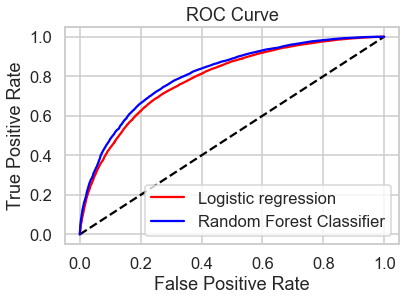

In [53]:
## prepare ROC curve plot
y_pred_prob_lg = clf.predict_proba(X_test)[:,1]
y_pred_prob_rf = rf.predict_proba(X_test)[:,1]


# Generate ROC curve values: fpr, tpr, thresholds
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, y_pred_prob_lg)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)


# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lg, tpr_lg, 'red', label='Logistic regression')
plt.plot(fpr_rf, tpr_rf, 'blue', label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

## Predict salary level of employed mothers in 2013:
Now we can run the Random Forest Classifier model on the latest data, 2013. The goal of this project is to predict salary of mothers in the workforce, since RFC has the best accuracy score, we will use that model instead.

In [73]:
# Set data to year 2013
data_2013 = data_final[data_final['YEAR']==2013].drop('GENDER_2', axis=1)
                        
# Identify variables
X = data_2013.loc[:, data_2013.columns != 'salary_d']
y = data_2013.loc[:, data_2013.columns == 'salary_d']

X.head()

,PERSONID,YEAR,AGE,NEWBUS,WAPRSM,SUPWK_0.0,SUPWK_1.0,DGRDG_1,DGRDG_2,DGRDG_3,...,EMSEC_3.0,EMSEC_4.0,EMSIZE_1.0,EMSIZE_2.0,EMSIZE_3.0,EMSIZE_4.0,EMSIZE_5.0,EMSIZE_6.0,EMSIZE_7.0,EMSIZE_8.0
91551,20000000003230008,2013,56,1.0,3.0,0,1,0,0,1,...,0,1,1,0,0,0,0,0,0,0
91553,20000000008220909,2013,59,0.0,3.0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
91554,20000000008250309,2013,58,0.0,1.0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
91556,20000000103230700,2013,61,0.0,1.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
91558,20000000104230409,2013,63,1.0,1.0,1,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0


In [74]:
os = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
columns = X_train.columns

os_data_X, os_data_y = os.fit_sample(X_train, y_train.values.ravel())
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['salary_d'])

X_os = os_data_X
y_os = np.ravel(os_data_y, order='C')

#check numbers of data
print('Length of oversampled data is',len(os_data_X))
print('Number of under $60k in oversampled data',len(os_data_y[os_data_y['salary_d']==0]))
print('Number of over $60k in oversampled data',len(os_data_y[os_data_y['salary_d']==1]))
print('Proportion of under $60k in oversampled data',len(os_data_y[os_data_y['salary_d']==0])/len(os_data_X))
print('Proportion of over $60k in oversampled data',len(os_data_y[os_data_y['salary_d']==1])/len(os_data_X))

Length of oversampled data is 87728
Number of under $60k in oversampled data 43864
Number of over $60k in oversampled data 43864
Proportion of under $60k in oversampled data 0.5
Proportion of over $60k in oversampled data 0.5


In [79]:
rf = RandomForestClassifier()
param_grid = {"n_estimators": [30, 50, 75],
              "max_features": [18],
              "max_depth": [10, 100, 300]}

grid_rf = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_rf.fit(X_os, y_os)

# Printing the best score from the model
print('Best Score:', grid_rf.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_rf.best_params_
print('Best Parameters:', best_params)

Best Score: 0.8002690133138792
Best Parameters: {'max_depth': 10, 'max_features': 18, 'n_estimators': 75}


In [80]:
#initiate a instance for classifier
rf = RandomForestClassifier(**best_params)

# Fit the classifier to the training data
rf.fit(X_os, y_os)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_test)

scores_rf_train = cross_val_score(rf, X_os, y_os, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
scores_rf_test = cross_val_score(rf, X_test, y_test.values.ravel(), cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

# Generate the classification report
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.80039(+/- 0.16)
Cross Validation Accuracy Scores - Test Set: 0.77257(+/- 0.01)
[[ 6539  3830]
 [ 2867 15995]]
Classification report on the test data:
              precision    recall  f1-score   support

         0.0       0.70      0.63      0.66     10369
         1.0       0.81      0.85      0.83     18862

   micro avg       0.77      0.77      0.77     29231
   macro avg       0.75      0.74      0.74     29231
weighted avg       0.77      0.77      0.77     29231



In [81]:
# Creating Data Frame with Features and Logistic Regression Coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(clf.coef_))], axis=1)
coefs_lg.columns = ['Attribute', 'Coef']
# Calculating exponentiated coefficients for interpretation
coefs_lg['Odds_Ratios'] = np.exp(coefs_lg['Coef'])
print('\nFeatures with the most impact on higher income levels for women')
coefs_lg.sort_values('Odds_Ratios', ascending=False).head(5)


Features with the most impact on higher income levels for women


,Attribute,Coef,Odds_Ratios
12,EMSEC_1.0,1.041190,2.832587
6,SUPWK_1.0,0.911112,2.487087
17,EMSIZE_2.0,0.843829,2.325252
5,SUPWK_0.0,0.581886,1.789410
16,EMSIZE_1.0,0.498461,1.646186


The greatest impact on mother's income level stem from employment sectors - specifically working in 2 year colleges or other school systems, having supervisory experience, and working in small companies.

# Predict job sector
Suppose you're a mother returning to the workforce, what type of sector should you expect to work in?

In [106]:
# Check columns in dataframe
data = df_emp_child

data.columns

Index(['PERSONID', 'YEAR', 'WEIGHT', 'SAMPLE', 'SURID', 'AGE', 'GENDER',
       'RACETH', 'CHTOT', 'DGRDG', 'LFSTAT', 'EMSEC', 'EMSIZE', 'NEWBUS',
       'WAPRSM', 'SUPWK', 'SALARY', 'CHFAM', 'SUPWK_0.0', 'SUPWK_1.0',
       'DGRDG_1', 'DGRDG_2', 'DGRDG_3', 'DGRDG_4', 'GENDER_1', 'GENDER_2',
       'EMSIZE_1.0', 'EMSIZE_2.0', 'EMSIZE_3.0', 'EMSIZE_4.0', 'EMSIZE_5.0',
       'EMSIZE_6.0', 'EMSIZE_7.0', 'EMSIZE_8.0'],
      dtype='object')

In [107]:
df_emp_child['EMSEC'].value_counts()

4.0    107597
2.0     35048
3.0     20596
1.0     13616
Name: EMSEC, dtype: int64

In [112]:
# Drop unnecessary columns
data_final_s = data.drop(['WEIGHT', 'SAMPLE', 'SURID', 'GENDER',
       'RACETH', 'CHTOT', 'DGRDG', 'LFSTAT', 'EMSIZE', 'NEWBUS',
       'WAPRSM', 'SUPWK', 'SALARY', 'CHFAM'], axis=1)

In [117]:
data_final_s.columns

Index(['PERSONID', 'YEAR', 'AGE', 'EMSEC', 'SUPWK_0.0', 'SUPWK_1.0', 'DGRDG_1',
       'DGRDG_2', 'DGRDG_3', 'DGRDG_4', 'GENDER_1', 'GENDER_2', 'EMSIZE_1.0',
       'EMSIZE_2.0', 'EMSIZE_3.0', 'EMSIZE_4.0', 'EMSIZE_5.0', 'EMSIZE_6.0',
       'EMSIZE_7.0', 'EMSIZE_8.0'],
      dtype='object')

In [139]:
# check for oversampling
#identify variables
X = data_final_s.loc[:, data_final_s.columns != 'EMSEC']
y = data_final_s.loc[:, data_final_s.columns == 'EMSEC']

pandas.core.frame.DataFrame

In [122]:
# split data
os = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
columns = X_train.columns

# balance training data set
os_data_X, os_data_y = os.fit_sample(X_train, np.ravel(y_train, order='C'))
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['EMSEC'])

X_oss = os_data_X
y_oss = np.ravel(os_data_y, order='C')


#check numbers of data
print('Length of oversampled data is',len(os_data_X))
print('Number of 2 yr colleges in oversampled data',len(os_data_y[os_data_y['EMSEC']==1]))
print('Number of 4 yr colleges in oversampled data',len(os_data_y[os_data_y['EMSEC']==2]))
print('Number of goverment jobs in oversampled data',len(os_data_y[os_data_y['EMSEC']==3]))
print('Number of industry jobs in oversampled data',len(os_data_y[os_data_y['EMSEC']==4]))
print('Proportion of 2 yr colleges in oversampled data',len(os_data_y[os_data_y['EMSEC']==1])/len(os_data_X))
print('Proportion of 4 yr colleges in data',len(os_data_y[os_data_y['EMSEC']==2])/len(os_data_X))
print('Proportion of government jobs in oversampled data',len(os_data_y[os_data_y['EMSEC']==3])/len(os_data_X))
print('Proportion of industry jobs in oversampled data',len(os_data_y[os_data_y['EMSEC']==4])/len(os_data_X))

Length of oversampled data is 301508
Number of 2 yr colleges in oversampled data 75377
Number of 4 yr colleges in oversampled data 75377
Number of goverment jobs in oversampled data 75377
Number of industry jobs in oversampled data 75377
Proportion of 2 yr colleges in oversampled data 0.25
Proportion of 4 yr colleges in data 0.25
Proportion of government jobs in oversampled data 0.25
Proportion of industry jobs in oversampled data 0.25


In [123]:
rf = RandomForestClassifier()
param_grid = {"n_estimators": [30, 50, 75],
              "max_features": [18],
              "max_depth": [10, 100, 300]}

grid_rf = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_rf.fit(X_oss, y_oss)

# Printing the best score from the model
print('Best Score:', grid_rf.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_rf.best_params_
print('Best Parameters:', best_params)

Best Score: 0.6259535402045717
Best Parameters: {'max_depth': 300, 'max_features': 18, 'n_estimators': 75}


In [125]:
#initiate a instance for classifier
rf = RandomForestClassifier(**best_params)

# Fit the classifier to the training data
rf.fit(X_oss, y_oss)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_test)

scores_rf_train = cross_val_score(rf, X_oss, y_oss, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
scores_rf_test = cross_val_score(rf, X_test, y_test.values.ravel(), cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

# Generate the classification report
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.62600(+/- 0.18)
Cross Validation Accuracy Scores - Test Set: 0.60396(+/- 0.01)
[[  957   609   266  2408]
 [  528  5080  1118  3737]
 [  327  1203  1111  3494]
 [ 1674  3143  2307 25096]]
Classification report on the test data:
              precision    recall  f1-score   support

         1.0       0.27      0.23      0.25      4240
         2.0       0.51      0.49      0.50     10463
         3.0       0.23      0.18      0.20      6135
         4.0       0.72      0.78      0.75     32220

   micro avg       0.61      0.61      0.61     53058
   macro avg       0.43      0.42      0.42     53058
weighted avg       0.59      0.61      0.60     53058



Pretty low accuracy score. Let's try binarizing EMSEC instead.

In [127]:
# define a function to find for a certain type job field only. 
# EMSEC = 1, 2 yr college or other
# EMSEC = 2, 4 yr college and medical
# EMSEC = 3, government
# EMSEC = 4, industry

def job_sec(ls):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s==4:
            new_s[i] = 1
        else:
            new_s[i] = 0
    return new_s

rd = job_sec(data_final_s['EMSEC'])

In [140]:
# Identify variables
y = rd

type(y)

numpy.ndarray

In [144]:
# split data
os = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
columns = X_train.columns

# balance training data set
os_data_X, os_data_y = os.fit_sample(X_train, np.ravel(y_train, order='C'))
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['EMSEC'])

#training variables
X_s = os_data_X
y_s = np.ravel(os_data_y, order='C')

In [145]:
rf = RandomForestClassifier()
param_grid = {"n_estimators": [30, 50, 75],
              "max_features": [18],
              "max_depth": [10, 100, 300]}

grid_rf = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_rf.fit(X_s, y_s)

# Printing the best score from the model
print('Best Score:', grid_rf.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_rf.best_params_
print('Best Parameters:', best_params)

Best Score: 0.7575719383896945
Best Parameters: {'max_depth': 10, 'max_features': 18, 'n_estimators': 75}


In [147]:
#initiate a instance for classifier
rf = RandomForestClassifier(**best_params)

# Fit the classifier to the training data
rf.fit(X_s, y_s)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_test)

scores_rf_train = cross_val_score(rf, X_s, y_s, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
scores_rf_test = cross_val_score(rf, X_test, y_test.ravel(), cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

# Generate the classification report
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.75730(+/- 0.16)
Cross Validation Accuracy Scores - Test Set: 0.72598(+/- 0.00)
[[12040  8798]
 [ 5790 26430]]
Classification report on the test data:
              precision    recall  f1-score   support

         0.0       0.68      0.58      0.62     20838
         1.0       0.75      0.82      0.78     32220

   micro avg       0.73      0.73      0.73     53058
   macro avg       0.71      0.70      0.70     53058
weighted avg       0.72      0.73      0.72     53058



In [148]:
# Creating Data Frame with Features and Random Forest Coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(clf.coef_))], axis=1)
coefs_lg.columns = ['Attribute', 'Coef']
# Calculating exponentiated coefficients for interpretation
coefs_lg['Odds_Ratios'] = np.exp(coefs_lg['Coef'])
print('\nFeatures with the most impact on job sector of industry: ')
coefs_lg.sort_values('Odds_Ratios', ascending=False).head(5)


Features with the most impact on job sector of industry: 


,Attribute,Coef,Odds_Ratios
12,EMSIZE_2.0,1.041190,2.832587
6,DGRDG_2,0.911112,2.487087
17,EMSIZE_7.0,0.843829,2.325252
5,DGRDG_1,0.581886,1.789410
16,EMSIZE_6.0,0.498461,1.646186


The top three greatest impact on working in industries with children is employment size of 11-24, having a master's degree, and employment size of 5000-24999.

In [ ]:
# define a function to binarize the target column

def job_sec(ls, n):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s==n:
            new_s[i] = 1
        else:
            new_s[i] = 0
    return new_s

train_score=[]
test_score=[]

for i in range(4):
    
    rd = job_sec(data_final_s['EMSEC'], i+1)
    
    # Identify variables
    X = data_final_s.drop('EMSEC', axis=1)
    y = rd

    # Splitting into train and test sets
    os = SMOTE(random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    columns = X_train.columns

    # balance training data set
    os_data_X, os_data_y = os.fit_sample(X_train, np.ravel(y_train, order='C'))
    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
    os_data_y = pd.DataFrame(data=os_data_y, columns=['EMSEC'])


    X_s = os_data_X
    y_s = np.ravel(os_data_y, order='C')

    clf = RandomForestClassifier()
    
    param_grid = {"n_estimators": [30, 50, 75],
              "max_features": [18],
              "max_depth": [10, 100]}

    grid_rf = GridSearchCV(clf, param_grid=param_grid, cv=5)
    grid_rf.fit(X_s, y_s)

    best_params = grid_rf.best_params_

    #initiate a instance for classifier
    rf = RandomForestClassifier(**best_params)

    # Fit the classifier to the training data
    rf.fit(X_s, y_s)

    # Predict the labels of the test data: y_pred
    y_pred = rf.predict(X_test)

    scores_rf_train = cross_val_score(rf, X_s, y_s, cv=5)
    train_score.append(scores_rf_train.mean())
    
    scores_rf_test = cross_val_score(rf, X_test, y_test, cv=5)
    test_score.append(scores_rf_test.mean())

In [152]:
# build a list contains the name of the work sector. 
score_sect_dic = ['2 yr college or other', '4 yr college or medical', 'Government', 'Industry']

In [153]:
score_df = pd.DataFrame(
    {'Field of Work': score_sect_dic,
     'Accuracy score on train': train_score,
     'Accuracy score on test': test_score
    })

score_df.sort_values('Accuracy score on test', ascending=False)

,Field of Work,Accuracy score on train,Accuracy score on test
0,2 yr college or other,0.931614,0.896038
2,Government,0.883916,0.852068
1,4 yr college or medical,0.863356,0.836349
3,Industry,0.758217,0.725885


Few insights from this table:

1. The random forest classification model works well in predicting job sectors! It predicts the employment sectors with accuracy scores ranging from 0.73 to 0.90.

2. 2 yr college, government and 4 yr college are top 3 most predictable sectors in this survey. From the random forest classifier results on the industry sector, we found that a company size of 11-24 people, having a masters degree, and a company size of 5000-25000 have the greatest impact on choosing job sectors. This means that people with children who work in industries tend to have a master's degree and work in either really small companies or really big ones. 

3. Industry sector is least accurately predicted. My thought on this is that people with children don't tend to stay or work in industries for many reasons: work schedule, financial pressure, and childcare, to name a few. The occurance of these could be more random and less predictable than the rest of the job fields. It causes a lower accuracy score.

# Summary
In this notebook, I explored some machine learning methods on the higher education SESTAT survey data, the leading surveys for studying the science and engineering (STEM) workforce.

I first prepared the target and predictor for a linear regression model. I tried linear regression model first because my target, salary, was a continuous value. I used age to predict salary; unfortunately, this method was not very strong. Mainly because age and salary did not share a linear relationship. As a result, I formatted salary into a binary column and used classification methods instead.

I prepared the target, numeric, and catagorical columns for the machine learning models. Statistical functions were used for feature selections. Then two classification models were picked to fit, cross validate and predict the salary level of the entries. I used accuracy scores and ROC curves to compare these methonds. It seems random forest classifier performed best, with an accuracy scores as high as 0.77.

In the last part, the princpal job sector was predicted. Which job sectors do parents expect when they go into the workforce? The random forest classifier help explained the major impacts in answering this question. Each job sector appeared was predicted with the employed with children portion of the data. The classification models does a great job in predicting the job sector in general. The results found some fields were more accurately predicted than others.